In [15]:
# Load the packages
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Libraries for missing values:
import missingno as msno   
# !pip install fancyimpute --target=/kaggle/working/
#import fancyimpute
warnings.filterwarnings("ignore")





In [16]:
# 2. Create interactive widgets in Jupyter notebooks
# Use Jupyter Widges Package - https://ipywidgets.readthedocs.io/en/stable/index.html 
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

# Configure pandas
pd.set_option('display.max_colwidth', None) # do not truncate column values
pd.set_option('display.max_rows', 200)      # max number of rows to display 
pd.set_option('display.max_columns', 300)   # max number of columns to display 

In [83]:
# Load the data
df_train = pd.read_csv("../datasets/train.csv", index_col='id')
df_test = pd.read_csv("../datasets/test.csv", index_col='id')

# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)[:-1]
target_feature = 'price'

df_train.head()


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


In [4]:
print("Train:",  df_train.shape)

print("Test:",  df_test.shape)

Train: (54273, 12)
Test: (36183, 11)


In [18]:
# only three numerical features in the data
# model_year  range [1974, 2024]
# milage [100, 405 000]
# price = target feature
df_train.describe()

,model_year,milage,price
count,54273.000000,54273.000000,5.427300e+04
mean,2015.091979,72746.175667,3.921844e+04
std,5.588909,50469.490448,7.282634e+04
min,1974.000000,100.000000,2.000000e+03
25%,2012.000000,32268.000000,1.550000e+04
50%,2016.000000,66107.000000,2.800000e+04
75%,2019.000000,102000.000000,4.500000e+04
max,2024.000000,405000.000000,2.954083e+06


In [52]:
# model: too many unique values @ 1827
# engine: too many unique values -> can be broken down with NLP 
# transmission: can be broken down with NLP
# ext_col and int_col: too many values?

# clean_title: redundant feature since only one value present

df_train.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,54273,54273,54273,54273,54273,54273,54273,54273,54273
unique,53,1827,7,1061,46,260,124,2,1
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,7369,780,49439,1452,16757,15078,31820,39896,54273


In [20]:
df_test.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,36183,36183,36183,36183,36183,36183,36183,36183,36183
unique,53,1791,7,1038,44,230,111,2,1
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,4854,496,33033,886,11273,10027,21122,26598,36183


In [61]:
# check for duplicates
num_duplicates = df_train.duplicated().sum()

if num_duplicates !=0:
    print(f'There are {num_duplicates} duplicate rows, removing them from the data.')
    df_train.drop_duplicates(inplace=True)
else:
    print(f'{num_duplicates} duplicate rows detected.')

0 duplicate rows detected.


In [54]:
# check for missing values
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df

df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [5]:
# Plotting the categorical variables in training and testing sets: ordered
# Define the function to plot the categorical variables
def count_plot(var, dataframe1, dataframe2):
    # Concatenate the two dataframes for the variable
    combined_data = pd.concat([dataframe1[var], dataframe2[var]]).dropna()
    
    # Determine the order of categories based on frequency
    category_order = combined_data.value_counts().index
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 
    
    # Plot training data
    sns.countplot(y=var, data=dataframe1, ax=axes[0], order=category_order)
    axes[0].set_title(f'Training Set - {var}')
    
    # Plot testing data
    sns.countplot(y=var, data=dataframe2, ax=axes[1], order=category_order)
    axes[1].set_title(f'Testing Set - {var}')
    
    plt.tight_layout()
    plt.show()

# Define a function for interactive plotting
def inter_cat_plot(x):
    return count_plot(x, df_train, df_test)


# Create a dropdown widget for selecting the categorical variable
widget_cat_plot = widgets.Dropdown(
    options=categorical_features,
    description="Categorical Variable:", 
    style=style
)

# Use interact to create an interactive plot
interact(inter_cat_plot, x=widget_cat_plot)

interactive(children=(Dropdown(description='Categorical Variable:', options=('brand', 'model', 'fuel_type', 'e…

<function __main__.inter_cat_plot(x)>

In [6]:
# Plot numerical variables:

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True) # Share both axes for comparison
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    plt.tight_layout()

def inter_num_plot(x):
    return histogram_plot(x, df_train, df_test)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage'), style=Desc…

<function __main__.inter_num_plot(x)>

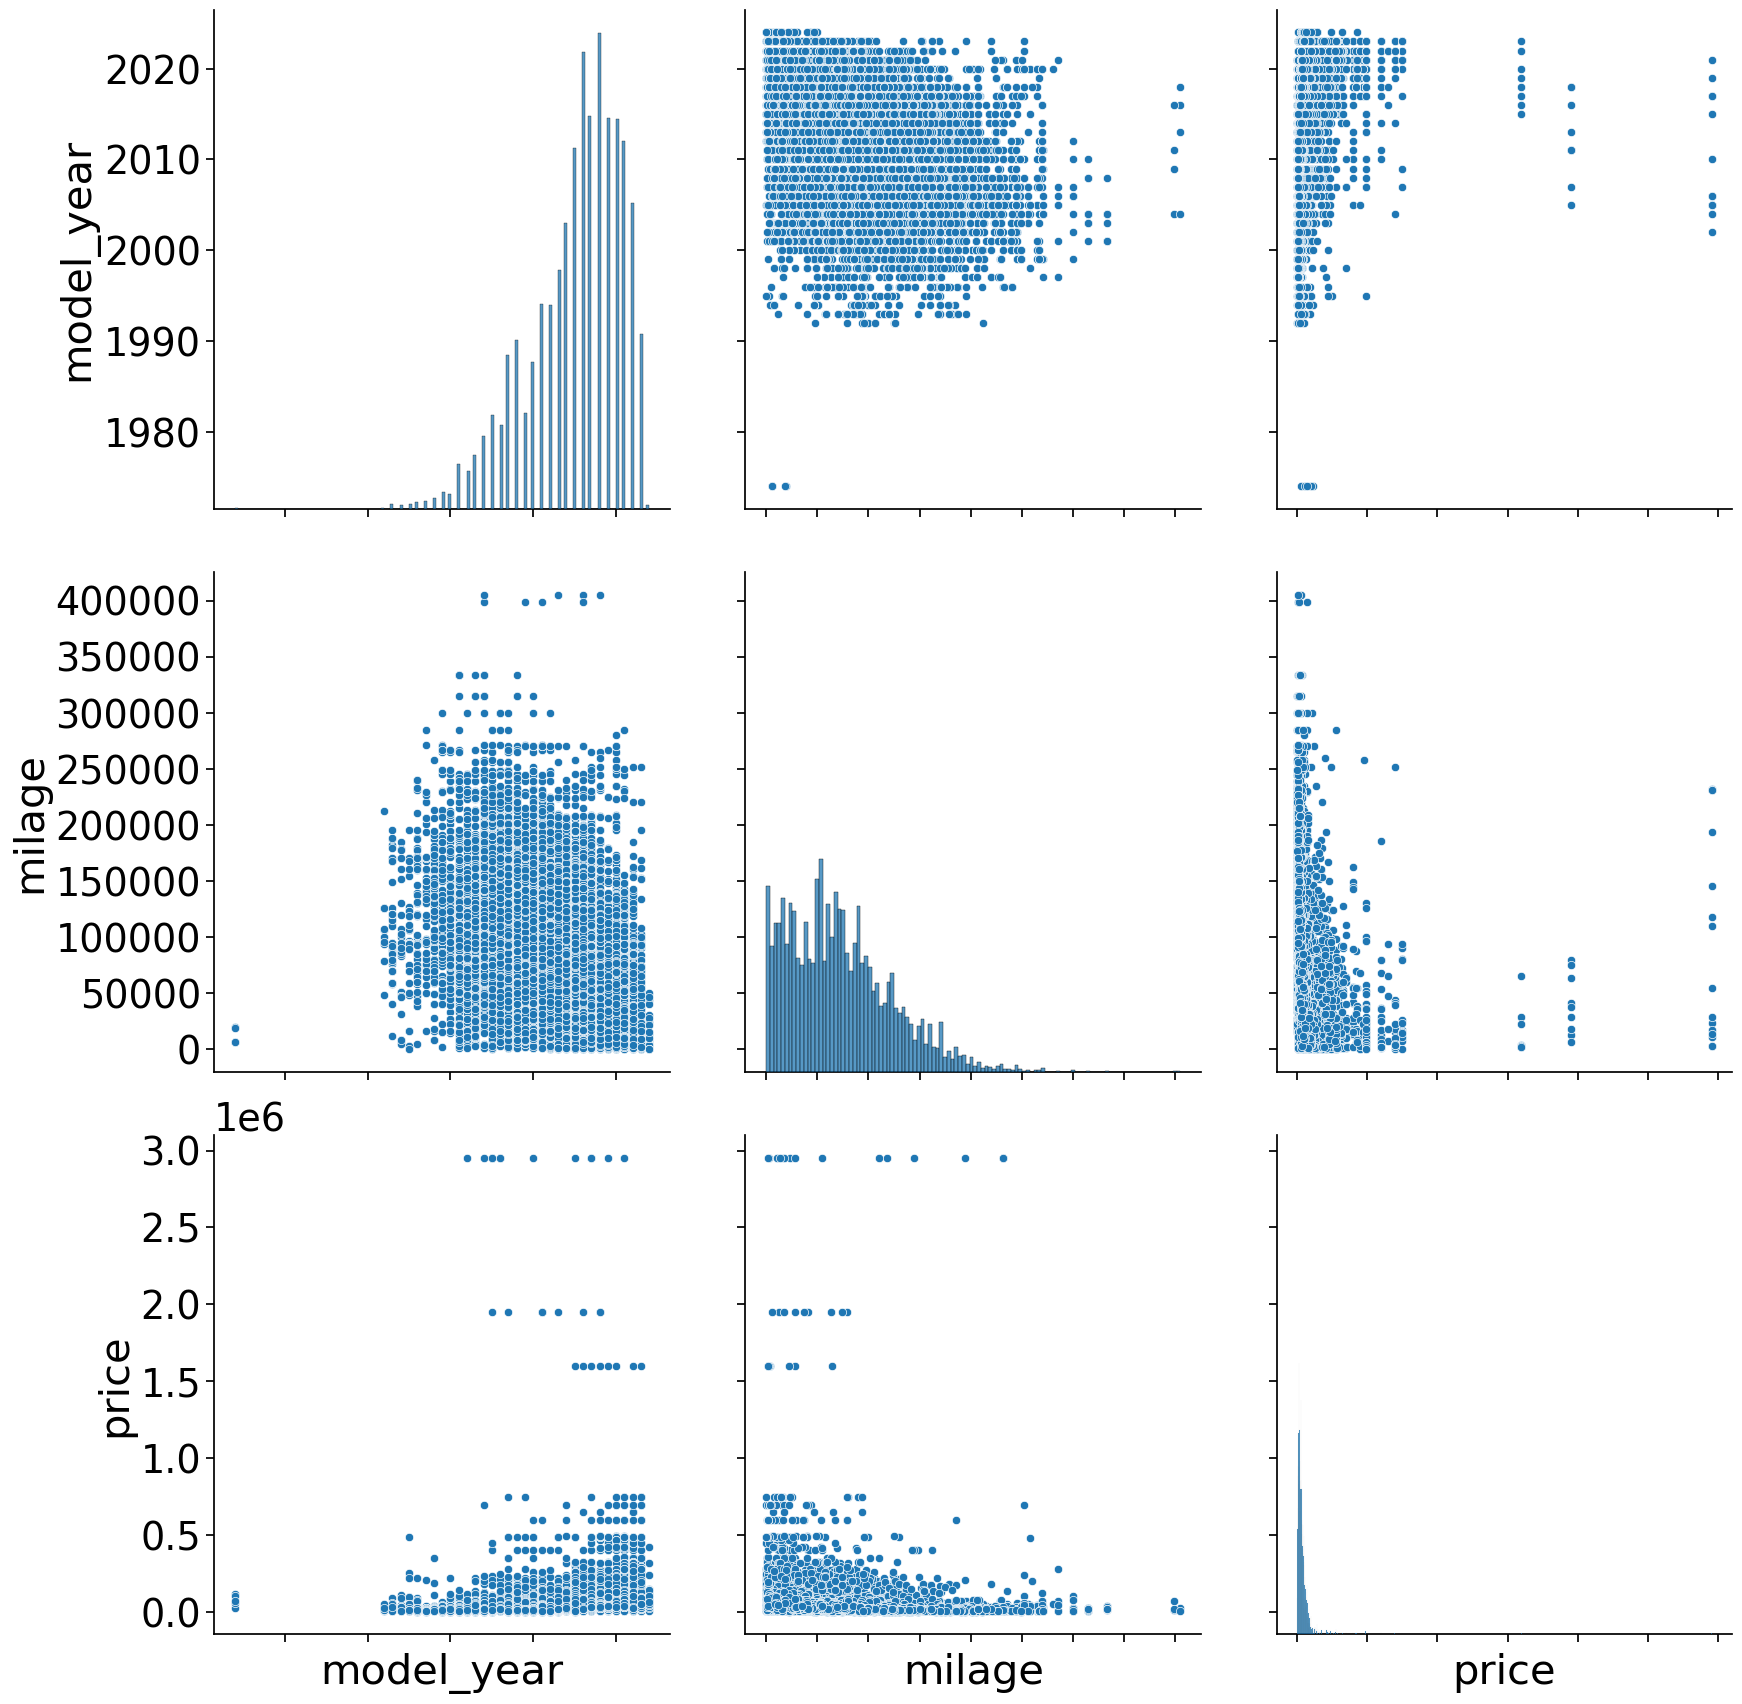

In [13]:
# scatter plot
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df_train.select_dtypes(include=['float64', 'int64']), 
                 #hue='price', 
                 palette='tab20',
                 size=6
                 )
g.set(xticklabels=[]);

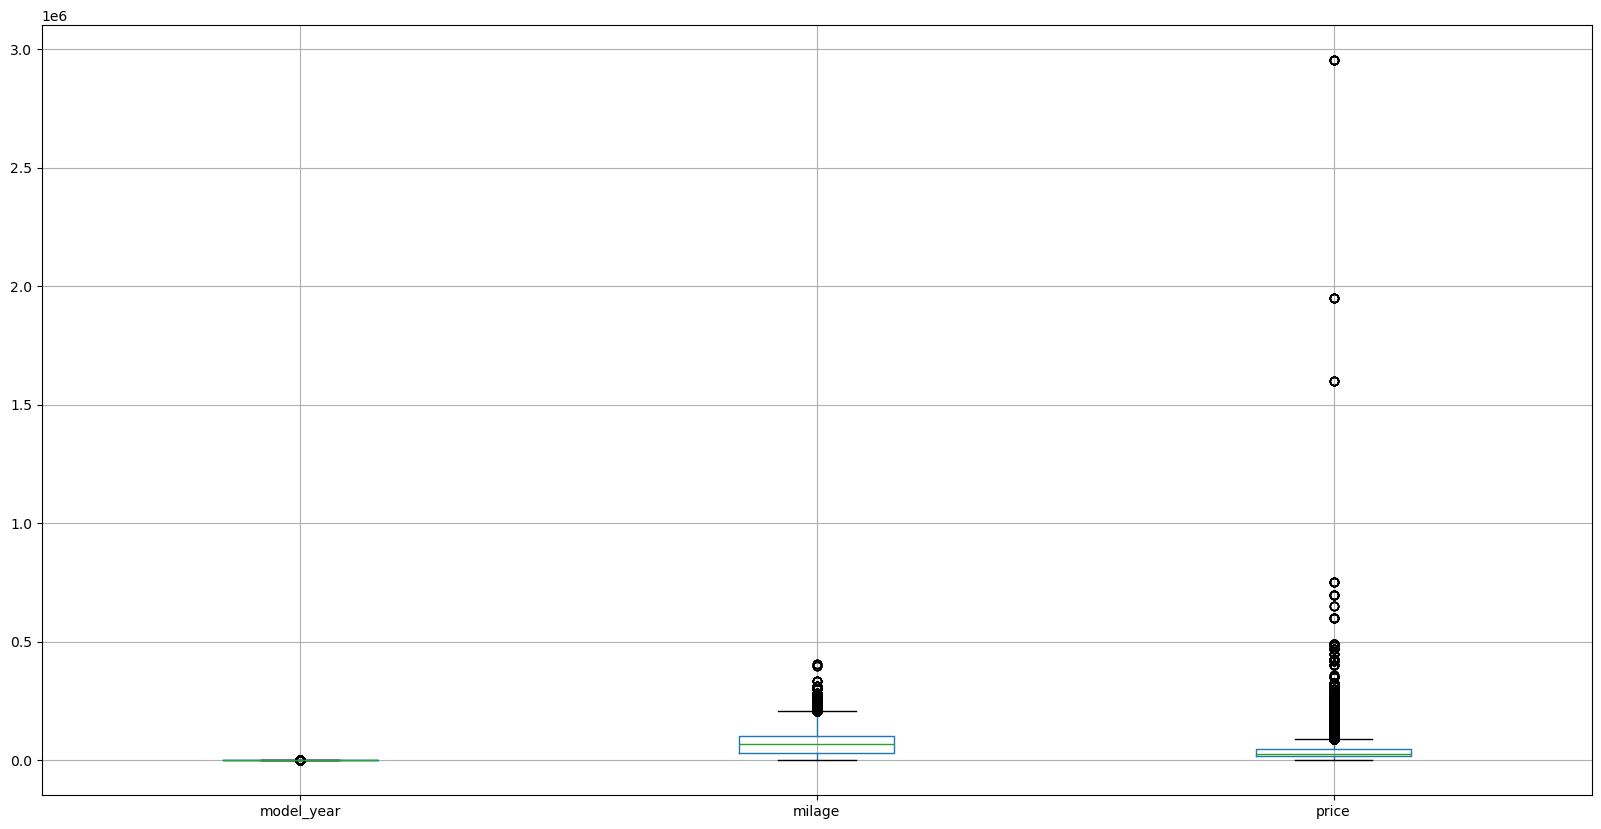

In [62]:
# identify outliers
df_train.boxplot(figsize=(20, 10))
plt.show()

In [63]:
# seems like some prices are incorrectly entered (maybe misplaced decimal?!)
df_train[df_train['price']>100000]


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
10,Maserati,Quattroporte S Q4 GranLusso,2018,34920,Gasoline,405.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Silver,Black,None reported,Yes,124995
16,Tesla,Model 3 Long Range,2021,21600,Gasoline,271.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,138999
19,Kia,Telluride LX,2022,14269,Gasoline,523.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,234000
35,Cadillac,Escalade ESV Platinum,2021,124000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Black,None reported,Yes,103500
72,Lexus,RX 350 F Sport Performance,2020,13500,Gasoline,295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Black,None reported,Yes,229900
...,...,...,...,...,...,...,...,...,...,...,...,...
54167,Chevrolet,Corvette Stingray w/2LT,2022,3273,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,A/T,White,Red,None reported,Yes,101999
54243,Bentley,Continental GT W12,2018,14806,Gasoline,621.0HP 6.0L 12 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Brown,None reported,Yes,234900
54254,Ford,Shelby GT350 Base,2018,18515,Gasoline,526.0HP 5.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gray,Black,None reported,Yes,215000


<Axes: >

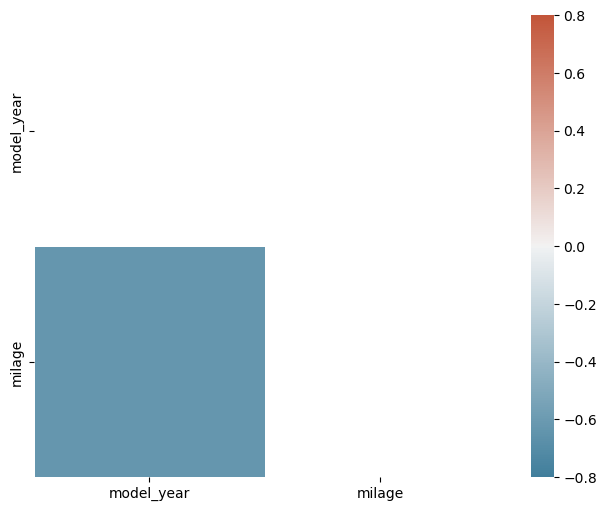

In [24]:
# Calculate correlation matrix 
# Check parameters: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html 
corr = df_train[numerical_features].corr() # method='pearson', 'kendall' , 'spearman'

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.8,vmax=0.8, square=True, linewidths=.5)

### Feature engineering

# model: too many unique values @ 1827
# engine: too many unique values -> can be broken down with NLP 
# transmission: can be broken down with NLP
# ext_col and int_col: too many values?

In [38]:
categorical_features

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

In [66]:
# brand: could be split into luxury, premium, regular
#print(sorted(df_train['brand'].unique()))

for i, brand in enumerate(sorted(df_test['brand'].unique())):
    print(brand, end='\t')
    if (i + 1) % 5 == 0:
        print()

Acura	Alfa	Aston	Audi	BMW	
Bentley	Bugatti	Buick	Cadillac	Chevrolet	
Chrysler	Dodge	FIAT	Ferrari	Ford	
GMC	Genesis	Honda	Hummer	Hyundai	
INFINITI	Jaguar	Jeep	Kia	Lamborghini	
Land	Lexus	Lincoln	Lotus	Lucid	
MINI	Maserati	Mazda	McLaren	Mercedes-Benz	
Mercury	Mitsubishi	Nissan	Pontiac	Porsche	
RAM	Rivian	Rolls-Royce	Saab	Saturn	
Scion	Subaru	Suzuki	Tesla	Toyota	
Volkswagen	Volvo	smart	

In [67]:
# Luxury, premium, and regular brand lists
luxury_brands = ['Aston', 'Audi', 'BMW', 'Bentley', 'Bugatti', 'Cadillac', 'Ferrari', 'Genesis', 'Jaguar', 'Lamborghini', 'Lexus', 'Lotus', 'Lucid', 'Maserati', 'Maybach', 'McLaren', 'Mercedes-Benz', 'Porsche', 'Rivian', 'Rolls-Royce', 'Saab']
premium_brands = ['Acura', 'Alfa', 'Buick','Chrysler', 'FIAT', 'INFINITI', 'Land', 'Lincoln', 'MINI', 'Tesla', 'Volvo', 'smart']
regular_brands = ['Chevrolet', 'Dodge', 'Ford', 'GMC', 'Honda', 'Hummer', 'Hyundai', 'Jeep', 'Kia', 'Mazda', 'Mercury', 'Mitsubishi', 'Nissan', 'Plymouth', 'Pontiac', 'RAM', 'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Toyota', 'Volkswagen']

# Function to assign labels based on brand category: ordinal 
def categorize_brand(brand):
    if brand in luxury_brands:
        return 3 #'Luxury'
    elif brand in premium_brands:
        return 2 #'Premium'
    elif brand in regular_brands:
        return 1 #'Regular'
    else:
        return 0 #'Other'

# Apply the function to create a new column 'brand_category'
df_train['brand_category'] = df_train['brand'].apply(categorize_brand)
df_test['brand_category'] = df_test['brand'].apply(categorize_brand)

df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category
id,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1


In [68]:
# brand_category (new feature)
#df_test.head()

for i, brand in enumerate(sorted(df_test['brand_category'].unique())):
    print(brand, end='\t')
    if (i + 1) % 5 == 0:
        print()


1	2	3	

In [82]:
# review cars over 100K not in luxury category
df_train[(df_train['price']> 200000) & 
         (df_train['brand_category']== 1) & 
         (df_train['brand'] == ('Chevrolet'
                                #'Ford'
                                )) ]


#df_train[(df_train['brand']== "Chevrolet") ]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category
id,,,,,,,,,,,,,
2802,Chevrolet,Corvette Z06,2015,41500,Gasoline,650.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gray,Black,At least 1 accident or damage reported,Yes,275000,1
3465,Chevrolet,Camaro 1SS,2017,39000,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Silver,Black,None reported,Yes,315000,1
4318,Chevrolet,Suburban LTZ,2017,67500,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,210000,1
4652,Chevrolet,Corvette Stingray w/1LT,2023,1100,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Red,None reported,Yes,259500,1
4755,Chevrolet,Corvette Stingray w/3LT,2023,5182,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,None reported,Yes,275000,1
7398,Chevrolet,Corvette Base,2007,14500,Gasoline,400.0HP 6.0L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Blue,Black,None reported,Yes,488880,1
7620,Chevrolet,Corvette Base,2005,231581,Gasoline,400.0HP 6.0L 8 Cylinder Engine Gasoline Fuel,4-Speed A/T,Gray,Beige,None reported,Yes,2954083,1
8384,Chevrolet,Corvette Stingray w/3LT,2022,1150,Gasoline,6.2L V8 16V GDI OHV Supercharged,Automatic,Black,–,None reported,Yes,279950,1
8772,Chevrolet,Corvette Base,2007,64000,Gasoline,400.0HP 6.0L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Red,Beige,None reported,Yes,349950,1


In [39]:
# bundle low frequency brand into other
# combine the training and test set
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# get freq for every brand based on the whole data
brand_freq = (df_combined['brand'].value_counts())/df_combined.shape[0]

# extract only 'high' frequency brands: could change to 5%
top_brands = brand_freq[brand_freq >= 0.02 ] # fi

# Replace less frequent brands with "other"
df_train['top_brand'] = df_train['brand'].apply(lambda x: 'other' if x not in top_brands else x)
df_test['top_brand'] = df_test['brand'].apply(lambda x: 'other' if x not in top_brands else x)

df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand
id,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1,Ford
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,other
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other


In [62]:
# model
#sorted(df_train['model'].unique())


for i, brand in enumerate(sorted(df_train['model'].unique())):
    print(brand, end='\t')
    if (i + 1) % 1 == 0:
        print()

124 Spider Abarth	
128 i	
135 i	
135 is	
1500 Big Horn	
1500 Cheyenne	
1500 Cheyenne Extended Cab	
1500 Classic SLT	
1500 Classic Tradesman	
1500 Classic Warlock	
1500 Laramie	
1500 Limited	
1500 Longhorn	
1500 Rebel	
1500 SLT	
1500 Sport	
1500 TRX	
1500 Tradesman/Express	
200 C	
200 Limited	
228 Gran Coupe i xDrive	
228 i	
230 i	
240SX Base	
2500 Big Horn	
2500 Laramie	
2500 Longhorn	
2500 Powerwagon	
2500 SLT	
2500 Tradesman	
300 Base	
300 S	
300 Touring	
300C Base	
300C SRT8	
300M Base	
300ZX Base	
320 i xDrive	
323 Ci	
325 Ci	
325 i	
325 xi	
328 i	
328 i xDrive	
328 xi	
330 330i xDrive	
330 i	
330 i xDrive	
330e iPerformance	
335 i	
335 i xDrive	
335 is	
340 i	
3500 Laramie	
3500 SLT	
3500 Tradesman	
350Z Enthusiast	
350Z NISMO	
350Z Touring	
370Z Base	
370Z NISMO	
370Z NISMO Tech	
370Z Touring	
428 Gran Coupe i xDrive	
428 i	
428 i xDrive	
428 i xDrive SULEV	
430 430i	
430 i	
430 i xDrive	
435 Gran Coupe i	
435 i	
435 i xDrive	
440 Gran Coupe 440i xDrive	
440 Gran Coupe i	
440 i x

In [83]:
df_train.groupby('brand')['model'].unique().reset_index()

,brand,model
0,Acura,"[Integra LS, MDX Technology, MDX Sport, TSX 2.4, TLX Type S PMC Edition, ZDX Base, ILX Technology Plus Package, MDX 3.7L Advance, TLX A-Spec, TL Type S, TSX Base, TLX V6 Advance, TLX V6 Tech, RL Technology, TL Technology, TLX PMC Edition, RDX Technology Package, ILX Premium Package, MDX Touring, TLX Base, RLX Advance Package, TLX Type S w/Performance Tire, TL 3.2, TL 3.7, RDX w/A-Spec Package, ILX 2.4L, ILX 2.0L w/Premium Package, NSX Base, MDX w/Technology Package, Integra GS-R, RSX Base, RDX Advance Package, RSX Type S, TSX Technology, Boxster S, Celica GT, TLX Tech, MDX 3.5L Technology Package, RDX PMC Edition, MDX 3.5L w/Advance & Entertainment Pkgs, ILX Premium & A-SPEC Packages, ES 350 Base, Elantra SE, RDX Base, BRZ Limited, MDX Sport Hybrid 3.0L w/Technology Package, TLX, Focus SE, MX-5 Miata Grand Touring, MDX w/Advance Package, SLK-Class SLK320, GTO Base]"
1,Alfa,"[Romeo Stelvio Quadrifoglio, Romeo Giulia Ti, Romeo Stelvio Ti Sport, Romeo Giulia Base, Romeo Stelvio Ti, Romeo Giulia Quadrifoglio, Romeo Stelvio Base, Ghibli S Q4, 488 GTB Base]"
2,Aston,"[Martin DBX Base, Martin V8 Vantage Base, Martin Vantage GT Base, Martin DBS Superleggera, Martin Vantage Base, Martin DB7 Vantage Volante]"
3,Audi,"[S5 3.0T Prestige, A3 2.0T Tech Premium, Q7 55 Prestige, A7 Premium, A4 2.0T Premium Plus quattro, A4 3.2 Premium Plus quattro, SQ5 3.0T Premium Plus, A4 2.0T Premium, S4 3.0 Prestige, A8 L 55, S3 2.0T Tech Premium Plus, S4 3.0T Premium Plus, RS 7 4.0T Prestige, Q5 2.0T Premium Plus, Q7 45 Premium Plus, A6 55 Premium, A3 2.0T Premium, A7 3.0T Premium Plus, Q8 55 Premium Plus, A6 55 Premium Plus, A7 3.0T Premium, R8 5.2, Q3 2.0T Premium Plus, A6 3.0 TDI Premium Plus, A5 2.0T Premium, RS 7 4.0T, A6 2.0T Premium Plus, A5 2.0T Premium Plus, A8 L 3.0T, S7 4.0T Premium Plus, Q5 2.0T Premium, R8 5.2 V10 plus, TT 2.0T Premium, Q7 3.0T Premium Plus, A4 2.0T Titanium Premium, R8 5.2 V10 performance, SQ5 3.0T Prestige, S4 3.0T Premium, A7 3.0T Prestige, A6 3.0T Prestige, Q7 3.0T Prestige, RS 7 4.0T Performance Prestige, A6 3.0T Premium Plus, TTS 2.0T Premium Plus, A4 2.0T Premium quattro, S5 3.0T Premium, A7 Premium Plus, A8 4.0T, S4 Base, S6 4.0T Prestige, A6 2.0T Sport, RS 4 Base, A7 55 Premium, TT 2.0T, RS Q8 4.0T quattro, S6 4.0T, S3 2.0T Premium Plus, RS 5 4.2, RS 5 2.9T, S8 4.0T Plus, R8 5.2 quattro Spyder, S5 3.0 Premium Plus, RSX Type S, A5 2.0T Prestige, Q7 3.0T Premium, Q8 3.0T Prestige, S6 4.0T Premium Plus, TT RS Base, S7 2.9T Prestige, A7 55 Premium Plus, S5 3.0T Premium Plus, RS Q8 4.0T, A8 L 4.0T, A6 45 Premium Plus, TT 1.8T, allroad 2.0T Prestige, A3 2.0T, S5 4.2 Premium Plus, A6 3.2 quattro, SQ7 4.0T, Q8 3.0T Premium, SQ5 3.0T Premium, 320 i xDrive, Q5 S line Premium Plus, A4 2.0T Premium Plus, AMG GT C, RS 4 4.2 quattro L, TT RS 2.5T, Edge Sport, Q5 3.0T Premium Plus, TT 1.8L, Panamera Edition, Romeo Giulia Base, A6 55 Prestige, Q3 45 S line Premium Plus, Bentayga V8, Q5 3.0 TDI Premium Plus, TT 3.2 Cabriolet quattro, RS 3 2.5T, WRX Base, ...]"
4,BMW,"[335 i, X7 xDrive40i, M340 i xDrive, 528 i xDrive, ALPINA B7 Base, X6 xDrive35i, M3 Base, X6 M Base, X3 xDrive30i, X6 xDrive40i, 740 iL, 435 i, X6 M50i, X5 xDrive40i, X5 xDrive35i, M6 Base, 228 i, 740 i, 328 i xDrive, X5 xDrive50i, M4 Base, X5 sDrive35i, 325 i, M4 Competition xDrive, X4 M Competition, 323 Ci, 750 i, X5 M Base, X1 xDrive 28i, M5 Base, X2 xDrive28i, M3 CS, Z4 3.0i Roadster, Z4 sDrive28i, 428 i xDrive SULEV, 440 i xDrive, TT 1.8T, 328 i, 330 i xDrive, 525 i, 650 Gran Coupe i, X6 xDrive50i, 750 i xDrive, M440 i, Beetle 2.0T S, 330 i, X1 xDrive28i, 335 i xDrive, 650 i, M2 CS, 428 Gran Coupe i xDrive, M240 i, M235 i, X3 xDrive28i, 435 Gran Coupe i, X5 M50i, 535 i xDrive, M550 i xDrive, 428 i xDrive, 840 i xDrive, X3 xDrive35i, 228 Gran Coupe i xDrive, 528 i, 135 i, 640 i, 300 Touring, X5 PHEV xDrive45e, X3 M AWD, X3 M40i, 640 Gran Coupe i, X1 sDrive28i, XJ8 Base, M850 i xDrive, 340 i, 435 i xDrive, X6 sDrive35i, 335 is, M3 Competition, R

In [40]:
# fuel type
print(sorted(df_train['fuel_type'].unique()))

# Replace 'not supported' and '–' with 'n/a'
df_train['fuel_type'] = df_train['fuel_type'].replace(['not supported', '–'], 'Unknown')
df_test['fuel_type'] = df_test['fuel_type'].replace(['not supported', '–'], 'Unknown')

print(sorted(df_train['fuel_type'].unique()))


['Diesel', 'E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Plug-In Hybrid', 'not supported', '–']
['Diesel', 'E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Plug-In Hybrid', 'Unknown']


In [23]:
# engine
for i, brand in enumerate(sorted(df_train['engine'].unique())):
    print(brand, end='\t')
    if (i + 1) % 5 == 0:
        print()

1.2L I3 12V GDI DOHC Turbo	1.3L I3 12V GDI DOHC Turbo	1.3L I3 12V MPFI DOHC Turbo	1.4L I4 16V GDI DOHC Turbo	1.5L I3 12V GDI DOHC Turbo	
1.5L I3 12V PDI DOHC Turbo	1.5L I4 16V GDI DOHC Turbo	1.6L I4 16V GDI DOHC Hybrid	1.6L I4 16V GDI DOHC Turbo	1.6L I4 16V MPFI DOHC	
101.0HP 1.4L 4 Cylinder Engine Gasoline Fuel	1020.0HP Electric Motor Electric Fuel System	104.0HP 1.6L 4 Cylinder Engine Gasoline Fuel	106.0HP 1.5L 4 Cylinder Engine Gasoline Fuel	109.0HP 1.5L 4 Cylinder Engine Gasoline Fuel	
109.0HP 1.6L 4 Cylinder Engine Gasoline Fuel	111.0HP Electric Motor Electric Fuel System	115.0HP 1.6L 4 Cylinder Engine Gasoline Fuel	115.0HP 1.7L 4 Cylinder Engine Gasoline Fuel	115.0HP 2.0L 4 Cylinder Engine Gasoline Fuel	
118.0HP 1.6L 4 Cylinder Engine Gasoline Fuel	120 AH	120.0HP 1.6L 4 Cylinder Engine Gasoline Fuel	120.0HP 2.2L 4 Cylinder Engine Flex Fuel Capability	120.0HP 2.5L 4 Cylinder Engine Gasoline Fuel	
121.0HP 1.8L 4 Cylinder Engine Gas/Electric Hybrid	122.0HP 1.8L 4 Cylinder Engine Gas

In [41]:
# Define a function to extract components of engine variable with NLP/regex
import re

def extract_engine_features(engine):
    features = {
        'power_output': None,
        'engine_size': None,
        'cylinders': None,
     #   'cylinder_layout': None,
     #   'valves': None,
     #   'aspiration': None,
       # 'fuels': None
    }
    
    # Extract power output
    power_output_match = re.search(r'(\d+(\.\d+)?)HP', engine)
    if power_output_match:
        features['power_output'] = float(power_output_match.group(1))
    
    # Extract engine size
    engine_size_match = re.search(r'(\d+\.\d+)L', engine)
    if engine_size_match:
        features['engine_size'] = float(engine_size_match.group(1))

    
    # Updated regex to capture standard numerical and prefixed notations
    cylinders_match = re.search(r'\b([VI]?\d+)\s?(Cylinder|Cyl|Engine|Fuel)\b', engine)
    if cylinders_match:
        # Check if the match is prefixed with 'V' or 'I'
        layout = cylinders_match.group(1)
        if layout.startswith('V') or layout.startswith('I'):
            features['cylinders'] = int(layout[1:])
        else:
            features['cylinders'] = int(layout)
        
    return features

'''

      # Extract cylinders
    cylinders_match = re.search(r'\b(\d+)\s?(Cylinder|Cyl|I\d|V\d)\b', engine)
    if cylinders_match:
        features['cylinders'] = int(cylinders_match.group(1))
       # features['cylinder_layout'] = cylinders_match.group(2)

    # Extract valves
    valves_match = re.search(r'(\d+)V', engine)
    if valves_match:
        features['valves'] = int(valves_match.group(1))
    
    # Extract aspiration
    if 'Turbo' in engine:
        features['aspiration'] = 'Turbo'
    elif 'Supercharged' in engine:
        features['aspiration'] = 'Supercharged'
    elif 'NA' in engine:
        features['aspiration'] = 'NA'
   
    # Extract fuel type
    if 'Gasoline' in engine:
        features['fuels'] = 'Gasoline'
    elif 'Diesel' in engine:
        features['fuels'] = 'Diesel'
    elif 'Electric' in engine:
        features['fuels'] = 'Electric'
    elif 'Hybrid' in engine:
        features['fuels'] = 'Hybrid'
    elif 'Flex Fuel' in engine:
        features['fuels'] = 'Flex Fuel'
'''
    
    

# Apply the function to the DataFrame
engine_features = df_train['engine'].apply(extract_engine_features).apply(pd.Series)
engine_features_test = df_test['engine'].apply(extract_engine_features).apply(pd.Series)

# Concatenate the original DataFrame with the new features
df_train = pd.concat([df_train, engine_features], axis=1)
df_test = pd.concat([df_test, engine_features_test], axis=1)

df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders
id,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1,Ford,375.0,3.5,6.0
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.0,3.0,6.0
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,other,300.0,4.2,8.0
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.0,3.0,6.0
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.0,3.8,6.0


In [42]:
#engine_features
pd.concat([df_train['engine'], engine_features], axis=1)

,engine,power_output,engine_size,cylinders
id,,,,
0,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,375.0,3.5,6.0
1,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,300.0,3.0,6.0
2,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,300.0,4.2,8.0
3,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,335.0,3.0,6.0
4,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,200.0,3.8,6.0
...,...,...,...,...
54268,445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,445.0,4.4,8.0
54269,220.0HP 2.0L 4 Cylinder Engine Flex Fuel Capability,220.0,2.0,4.0
54270,420.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,420.0,3.6,6.0


In [34]:
# transmission
for i, brand in enumerate(sorted(df_train['transmission'].unique())):
    print(brand, end='\t')
    if (i + 1) % 2 == 0:
        print()

1-Speed A/T	1-Speed Automatic	
10-Speed A/T	10-Speed Automatic	
10-Speed Automatic with Overdrive	2-Speed A/T	
4-Speed A/T	4-Speed Automatic	
5-Speed A/T	5-Speed Automatic	
5-Speed M/T	6 Speed At/Mt	
6 Speed Mt	6-Speed	
6-Speed A/T	6-Speed Automatic	
6-Speed Automatic with Auto-Shift	6-Speed Electronically Controlled Automatic with O	
6-Speed M/T	6-Speed Manual	
7-Speed	7-Speed A/T	
7-Speed Automatic	7-Speed Automatic with Auto-Shift	
7-Speed DCT Automatic	7-Speed M/T	
7-Speed Manual	8-Speed A/T	
8-Speed Automatic	8-Speed Automatic with Auto-Shift	
8-Speed Manual	9-Speed A/T	
9-Speed Automatic	9-Speed Automatic with Auto-Shift	
A/T	Automatic	
Automatic CVT	CVT Transmission	
CVT-F	F	
M/T	SCHEDULED FOR OR IN PRODUCTION	
Transmission Overdrive Switch	Transmission w/Dual Shift Mode	
Variable	–	


In [43]:
# Define a function to extract speed and transmission type
def extract_transmission_features(transmission):
    features = {
        'speed': None,
        'transmission_type': None
    }
    
    # Extract speed
    speed_match = re.search(r'(\d+)-? ?Speed', transmission, re.IGNORECASE)
    if speed_match:
        features['speed'] = int(speed_match.group(1))
    
    # Define types of transmissions
    if 'Automatic' in transmission or 'A/T' in transmission:
        features['transmission_type'] = 'Automatic'
    elif 'Manual' in transmission or 'M/T' in transmission or 'Mt' in transmission:
        features['transmission_type'] = 'Manual'
    elif 'CVT' in transmission or 'Variable' in transmission:
        features['transmission_type'] = 'CVT'
    elif 'DCT' in transmission or 'Dual' in transmission or 'At/Mt' in transmission:
        features['transmission_type'] = 'AM'
    else:
        features['transmission_type'] = 'Unknown'
    
    return features


# Apply the function to the DataFrame
trans_features = df_train['transmission'].apply(extract_transmission_features).apply(pd.Series)
trans_features_test = df_test['transmission'].apply(extract_transmission_features).apply(pd.Series)

# Concatenate the original DataFrame with the new features
df_train = pd.concat([df_train, trans_features], axis=1)
df_test = pd.concat([df_test, trans_features_test], axis=1)

df_train.head()
#df_train[df_train['transmission'] == 'F']



,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type
id,,,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1,Ford,375.0,3.5,6.0,10.0,Automatic
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.0,3.0,6.0,6.0,Manual
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,other,300.0,4.2,8.0,6.0,Automatic
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.0,3.0,6.0,NaN,AM
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.0,3.8,6.0,NaN,Automatic


In [67]:
# ext_col
for i, brand in enumerate(sorted(df_train['ext_col'].unique())):
    print(brand, end='\t')
    if (i + 1) % 2 == 0:
        print()

Agate Black Metallic	Alfa White	
Alpine White	Alta White	
Ametrin Metallic	Anodized Blue Metallic	
Antimatter Blue Metallic	Arctic White	
Atomic Silver	Balloon White	
Baltic Gray	Bayside Blue	
Beige	Beluga Black	
Bianco Icarus Metallic	Bianco Isis	
Billet Silver Metallic Clearcoat	Black	
Black Cherry	Black Clearcoat	
Black Forest Green	Black Noir Pearl	
Black Obsidian	Black Raven	
Black Sapphire Metallic	Blu	
Blue	Blue Caelum	
Blue Metallic	Blue Reflex Mica	
Blueprint	Brands Hatch Gray Metallic	
Bright White Clearcoat	Brilliant Black	
Brilliant Silver Metallic	Bronze Dune Metallic	
Brown	Burnished Bronze Metallic	
C / C	Cajun Red Tintcoat	
Carbon Black Metallic	Carbonized Gray Metallic	
Carpathian Grey	Carpathian Grey Premium Metallic	
Carrara White Metallic	Caspian Blue	
Caviar	Cayenne Red Tintcoat	
Chalk	China Blue	
Cirrus Silver Metallic	Cobra Beige Metallic	
Crimson Red Tintcoat	Crystal Black Pearl	
Crystal Black Silica	Custom Color	
DB Black Clearcoat	Dark Ash Metallic	
Dark Graph

In [51]:
# int_col
for i, brand in enumerate(sorted(df_train['int_col'].unique())):
    print(brand, end='\t')
    if (i + 1) % 5 == 0:
        print()

AMG Black	Adrenaline Red	Almond Beige	Amber	Ash	
BLACK	Beige	Beluga	Beluga Hide	Black	
Black / Brown	Black / Express Red	Black / Graphite	Black / Gray	Black / Saddle	
Black / Stone Grey	Black Onyx	Black w/Red Stitching	Black/Gun Metal	Black/Red	
Blk	Blue	Boulder	Brandy	Brown	
Camel	Camel Leather	Canberra Beige	Canberra Beige/Black	Cappuccino	
Caramel	Ceramic	Charcoal	Charcoal Black	Charles Blue	
Chestnut	Cloud	Cobalt Blue	Cocoa / Dune	Dark Ash	
Dark Auburn	Dark Galvanized	Dark Gray	Deep Chestnut	Deep Cypress	
Deep Garnet	Diesel Gray / Black	Ebony	Ebony / Ebony Accents	Ebony / Pimento	
Ebony Black	Espresso	Giallo Taurus / Nero Ade	Global Black	Gold	
Grace White	Graphite	Gray	Graystone	Green	
Hotspur	Hotspur Hide	Ice	Ivory / Ebony	Jet Black	
Kyalami Orange	Light Gray	Light Platinum / Jet Black	Light Slate	Light Titanium	
Linen	Macchiato	Medium Ash Gray	Medium Dark Slate	Medium Earth Gray	
Medium Light Camel	Medium Pewter	Medium Stone	Mesa	Mistral Gray / Raven	
Mocha	Mountain Brown	Navy P

In [44]:
# Mapping of basic colors to their associated keywords
color_keywords = {
    'black': ['black', 'beluga', 'ebony', 'nero', 'onyx', 'graphite', 'blk', 'carbon'],
    'white': ['white', 'bianco', 'whisper', 'ivory', 'linen', 'cashmere'],
    'silver': ['silver', 'ceramic', 'pewter'],
    'red': ['red', 'pimento', 'rioja', 'hotspur', 'adrenaline', 'cajun'],
    'blue': ['blue', 'blu', 'anodized', 'caelum', 'cobalt', 'charles', 'rhapsody'],
    'grey': ['gray', 'grey', 'slate', 'graphite', 'magnetite', 'mistral'],
    'brown': ['brown', 'beige', 'saddle', 'tan', 'camel', 'chestnut', 'mocha', 'nougat', 'espresso', 'brandy'],
    'others': []  # This will catch anything not mapped to the above colors
}

# Function to map color to basic color based on keywords
def map_to_basic_color(color):
    color_lower = color.lower()
    for basic_color, keywords in color_keywords.items():
        if any(keyword in color_lower for keyword in keywords):
            return basic_color
    return 'others'

# Apply the function to create a new column

# Create a new column 'basic_color' and apply the function to it
df_train['ext_color_basic'] = df_train['ext_col'].apply(map_to_basic_color)
df_test['ext_color_basic'] = df_test['ext_col'].apply(map_to_basic_color)

df_train['int_color_basic'] = df_train['int_col'].apply(map_to_basic_color)
df_test['int_color_basic'] = df_test['int_col'].apply(map_to_basic_color)


#print(df_train[['ext_col', 'ext_color_basic']])


In [45]:
# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (54273, 21)
Shape of testing set: (36183, 20)


In [46]:
df_train


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1,Ford,375.0,3.5,6.0,10.0,Automatic,blue,grey
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.0,3.0,6.0,6.0,Manual,black,black
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,other,300.0,4.2,8.0,6.0,Automatic,others,brown
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.0,3.0,6.0,NaN,AM,grey,brown
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.0,3.8,6.0,NaN,Automatic,white,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,BMW,X6 xDrive50i,2017,29000,Gasoline,445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Brown,None reported,Yes,29000,3,BMW,445.0,4.4,8.0,8.0,Automatic,white,brown
54269,Audi,A4 2.0T Premium,2015,94634,E85 Flex Fuel,220.0HP 2.0L 4 Cylinder Engine Flex Fuel Capability,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,6500,3,Audi,220.0,2.0,4.0,6.0,Automatic,black,black
54270,Porsche,Cayenne S,2013,40989,Gasoline,420.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,At least 1 accident or damage reported,Yes,18950,3,Porsche,420.0,3.6,6.0,NaN,AM,white,black


### Further review of the features

In [50]:
df_train['age'] = 2024 - df_train['model_year']
df_test['age'] = 2024 - df_test['model_year']

df_train['miles_per_year'] = df_train['milage']/df_train['age']
df_test['miles_per_year'] = df_test['milage']/df_test['age']

df_train

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,age,miles_per_year
id,,,,,,,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1,Ford,375.0,3.5,6.0,10.0,Automatic,blue,grey,6,12391.500000
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.0,3.0,6.0,6.0,Manual,black,black,17,4705.882353
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,other,300.0,4.2,8.0,6.0,Automatic,others,brown,15,6099.400000
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.0,3.0,6.0,NaN,AM,grey,brown,2,1218.500000
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.0,3.8,6.0,NaN,Automatic,white,black,23,4826.086957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,BMW,X6 xDrive50i,2017,29000,Gasoline,445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Brown,None reported,Yes,29000,3,BMW,445.0,4.4,8.0,8.0,Automatic,white,brown,7,4142.857143
54269,Audi,A4 2.0T Premium,2015,94634,E85 Flex Fuel,220.0HP 2.0L 4 Cylinder Engine Flex Fuel Capability,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,6500,3,Audi,220.0,2.0,4.0,6.0,Automatic,black,black,9,10514.888889
54270,Porsche,Cayenne S,2013,40989,Gasoline,420.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,At least 1 accident or damage reported,Yes,18950,3,Porsche,420.0,3.6,6.0,NaN,AM,white,black,11,3726.272727


In [59]:


#df_train.groupby('brand')['price'].mean().reset_index().sort_values(by='price', ascending=False)

df_train[df_train['price'] > 100000]
#.sort_values(by='Price', ascending=False)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,age,miles_per_year
id,,,,,,,,,,,,,,,,,,,,,,,
10,Maserati,Quattroporte S Q4 GranLusso,2018,34920,Gasoline,405.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Silver,Black,None reported,Yes,124995,3,other,405.0,3.0,6.0,NaN,Automatic,silver,black,6,5820.000000
16,Tesla,Model 3 Long Range,2021,21600,Gasoline,271.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,138999,2,other,271.0,NaN,NaN,NaN,Automatic,black,black,3,7200.000000
19,Kia,Telluride LX,2022,14269,Gasoline,523.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,234000,1,other,523.0,4.4,8.0,8.0,Automatic,black,black,2,7134.500000
35,Cadillac,Escalade ESV Platinum,2021,124000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Black,None reported,Yes,103500,3,Cadillac,420.0,6.2,8.0,10.0,Automatic,black,black,3,41333.333333
72,Lexus,RX 350 F Sport Performance,2020,13500,Gasoline,295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Black,None reported,Yes,229900,3,Lexus,295.0,3.5,6.0,8.0,Automatic,grey,black,4,3375.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54167,Chevrolet,Corvette Stingray w/2LT,2022,3273,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,A/T,White,Red,None reported,Yes,101999,1,Chevrolet,490.0,6.2,8.0,NaN,Automatic,white,red,2,1636.500000
54243,Bentley,Continental GT W12,2018,14806,Gasoline,621.0HP 6.0L 12 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Brown,None reported,Yes,234900,3,other,621.0,6.0,12.0,8.0,Automatic,black,brown,6,2467.666667
54254,Ford,Shelby GT350 Base,2018,18515,Gasoline,526.0HP 5.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gray,Black,None reported,Yes,215000,1,Ford,526.0,5.2,8.0,6.0,Manual,grey,black,6,3085.833333


In [47]:
# saving the new dataframes
df_train.to_csv('../datasets/train_new.csv')
df_test.to_csv('../datasets/test_new.csv')


Sources:

https://www.kaggle.com/competitions/kagglex-cohort4/overview

